In [119]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sns
import sys
import os
sys.path.append('/Users/vs/Dropbox/Python')

### From Gaia documentation to do command line requests to Gaia DR1 archive
import httplib
import urllib
import time
from xml.dom.minidom import parseString

sns.set_style("white")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})
sns.set_palette(sns.husl_palette(10, l=.4))
colors = sns.color_palette()


# variable_star_visualisation

** 
Notebook to visualise variable star photometry from the Gaia DR1 data release**

Vicky Scowcroft

Last update: October 16th 2016


In [120]:
def run_gaia_query(adql_query, outputFileName):
    host = "gea.esac.esa.int"
    port = 80
    pathinfo = "/tap-server/tap/async"
    headers = {"Content-type": "application/x-www-form-urlencoded", "Accept":       "text/plain"}
    params = urllib.urlencode({"REQUEST": "doQuery", "LANG": "ADQL", "FORMAT": "csv", "PHASE":  "RUN", "QUERY": adql_query})

    connection = httplib.HTTPConnection(host, port)
    connection.request("POST",pathinfo,params,headers)

    #Status
    response = connection.getresponse()
    print "Status: " +str(response.status), "Reason: " + str(response.reason)

    #Server job location (URL)
    location = response.getheader("location")
    print "Location: " + location

    #Jobid
    jobid = location[location.rfind('/')+1:]
    print "Job id: " + jobid

    connection.close()

    #-------------------------------------
    #Check job status, wait until finished

    while True:
        connection = httplib.HTTPConnection(host, port)
        connection.request("GET",pathinfo+"/"+jobid)
        response = connection.getresponse()
        data = response.read()
        #XML response: parse it to obtain the current status
        dom = parseString(data)
        phaseElement = dom.getElementsByTagName('uws:phase')[0]
        phaseValueElement = phaseElement.firstChild
        phase = phaseValueElement.toxml()
        print "Status: " + phase
        #Check finished
        if phase == 'COMPLETED': break
        #wait and repeat
        time.sleep(0.2)

    #print "Data:"
    #print data

    connection.close()

    #-------------------------------------
    #Get results
    connection = httplib.HTTPConnection(host, port)
    connection.request("GET",pathinfo+"/"+jobid+"/results/result")
    response = connection.getresponse()
    data = response.read()
    outputFile = open(outputFileName, "w")
    outputFile.write(data)
    outputFile.close()
    connection.close()
    print "Data saved in: " + outputFileName
    return(0)



In [121]:
adql_query = "SELECT * FROM gaiadr1.variable_summary WHERE source_id IN (SELECT source_id FROM gaiadr1.gaia_source WHERE (phot_variable_flag='VARIABLE'))"
run_gaia_query(adql_query, 'variable_stars.csv')

adql_query = "SELECT * FROM gaiadr1.gaia_source WHERE (phot_variable_flag='VARIABLE')"
run_gaia_query(adql_query, 'variable_stars_sourceinfo.csv')


Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1476378622401O
Job id: 1476378622401O
Status: EXECUTING
Status: EXECUTING
Status: COMPLETED
Data saved in: variable_stars.csv
Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1476378623557O
Job id: 1476378623557O
Status: EXECUTING
Status: EXECUTING
Status: COMPLETED
Data saved in: variable_stars_sourceinfo.csv


0

In [122]:
variables_df = pd.read_csv('variable_stars.csv', header=0, sep=',')
variables_extended = pd.read_csv('variable_stars_sourceinfo.csv', header=0, sep=',')

variables_df = variables_df.merge(variables_extended, on='source_id')
variables_df = variables_df.rename(columns={'solution_id_x':'solution_id_var', 'solution_id_y': 'solution_id_source'})
variables_df['Period'] = variables_df.apply(lambda x: 1./x.phot_variable_fundam_freq1, axis=1)
useful = ['source_id', 'classification', 'Period', 'ra', 'dec', 'l', 'b', 'parallax', 'parallax_error', 'phot_g_mean_mag']

In [143]:
### Now grab the photometry for one of these stars
grabstar = np.random.randint(len(variables_df))
star_id = variables_df.source_id[grabstar]

adql_query = "SELECT * FROM gaiadr1.phot_variable_time_series_gfov  WHERE (source_id={0})".format(star_id)
phot_filename = 'phot_files/' + str(star_id) + '_phot.csv'
run_gaia_query(adql_query, phot_filename)

period = variables_df.ix[variables_df.source_id==star_id, 'Period'].values[0]
phot_df = pd.read_csv(phot_filename, header=0, sep=',')
phot_df['BJD'] = phot_df.apply(lambda x: x.observation_time + 2455197.5, axis=1)
phot_df['g_mag_err'] = phot_df.apply(lambda x: 1.086*x.g_flux_error/x.g_flux, axis=1)
phot_df['Phase'] = phot_df.apply(lambda x: ((x.BJD/ period) - np.floor(x.BJD / period)), axis=1)


Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1476379425411O
Job id: 1476379425411O
Status: COMPLETED
Data saved in: phot_files/4660192971073067392_phot.csv


,source_id,classification,Period,ra,dec,l,b,parallax,parallax_error,phot_g_mean_mag
2066,4660192971073067392,RRLYR,0.344242,81.503537,-67.186175,277.399163,-33.09148,NaN,NaN,19.105054


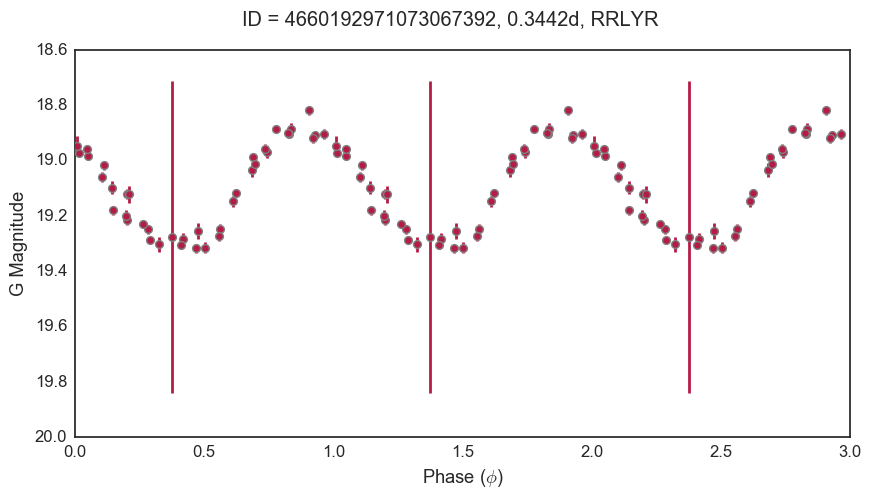

In [144]:
mp.clf()
mp.figure(figsize=(10,5))
mp.errorbar(np.concatenate((phot_df.Phase, phot_df.Phase + 1.0, phot_df.Phase + 2.0)) , np.concatenate((phot_df.g_magnitude, phot_df.g_magnitude, phot_df.g_magnitude)), yerr = np.concatenate((phot_df.g_mag_err, phot_df.g_mag_err, phot_df.g_mag_err)), ls='None',zorder=4, color=pointcols, label='_nolegend_')
mp.plot(np.concatenate((phot_df.Phase, phot_df.Phase + 1.0, phot_df.Phase + 2.0)) , np.concatenate((phot_df.g_magnitude, phot_df.g_magnitude, phot_df.g_magnitude)), 'o', color=colors[0], ls='None', zorder=4, markeredgecolor='Grey', markeredgewidth=1, label='G')
mp.gca().invert_yaxis()
mp.xlabel('Phase ($\phi$)')
mp.ylabel('G Magnitude')
titletext = 'ID = ' + str(star_id) + ', ' + str(np.around(period, decimals=4)) + 'd, ' + variables_df.ix[variables_df.source_id==star_id, 'classification'].values[0]
mp.suptitle(titletext)
variables_df.ix[variables_df.source_id==star_id, useful]